In [122]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import dlib
from sklearn.model_selection import train_test_split
from sklearn import svm
from keras.preprocessing import image
from sklearn import decomposition
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import metrics
from skimage.color import rgb2gray
from skimage.feature import hog
import matplotlib.pyplot as plt
import matplotlib.image as mapimg

In [123]:
file_path = "D:\Admin\Documents\Year_4\AMLS\Assessment\dataset_AMLS_20-21\cartoon_set\img"
labels_path = "D:\Admin\Documents\Year_4\AMLS\Assessment\dataset_AMLS_20-21\cartoon_set\labels.csv"

In [124]:
df = pd.read_csv(labels_path)

df = df.drop(columns="Unnamed: 0")
temp = df["file_name"]
df.insert(loc=0, column="file_names", value=temp)
df = df.drop(columns="file_name")
df = df.drop(df.index[1000:])

In [125]:
train, validation, test = \
              np.split(df.sample(frac=1), 
                       [int(.6*len(df)), int(.8*len(df))])

In [126]:
train

,file_names,eye_color,face_shape
890,890.png,0,3
205,205.png,4,2
539,539.png,2,0
585,585.png,3,1
956,956.png,1,2
...,...,...,...
246,246.png,1,4
583,583.png,4,3
700,700.png,2,1
326,326.png,1,0


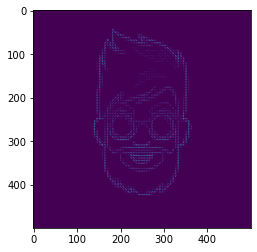

In [136]:
b = "D:/Admin/Documents/Year_4/AMLS/Assessment/dataset_AMLS_20-21/cartoon_set/img/0.png"
b = mapimg.imread(b)
fd, hog_image = hog(b, pixels_per_cell=(6,6), visualize=True)
plt.imshow(hog_image)
plt.show()

In [26]:
labels_file = open('D:\Admin\Documents\Year_4\AMLS\Assessment\dataset_AMLS_20-21\cartoon_set\labels.csv', 'r')
lines = labels_file.readlines()
lines = lines[1:]
fs_label = {}
for line in lines:
    fs_label[line.split(',')[3]] = line.split(',')[2]

In [35]:
count = 5
for key in fs_label:
    print(key)
    if count <=0:
        break
    count -= 1

0.png

1.png

2.png

3.png

4.png

5.png



In [69]:
def shape_to_np(shape, dtype="int"):
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    return coords

In [70]:
def rect_to_dim(rect):
    w = rect.right() - rect.left()
    h = rect.top() - rect.bottom()
    return (w, h)

In [71]:
def create_feature(img):
    face_detect = dlib.get_frontal_face_detector()
    shape_predict = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = gray.astype('uint8')
    rects = face_detect(gray, 1)
    num_faces = len(rects)
    
    if num_faces == 0:
        return None

    face_areas = np.zeros((1, num_faces))
    face_shapes = np.zeros((136, num_faces), dtype=np.int64)
    
    for (i, rect) in enumerate(rects):
        temp_shape = shape_predict(gray, rect)
        temp_shape = shape_to_np(temp_shape)
        (w, h) = rect_to_dim(rect)
        face_shapes[:, i] = np.reshape(temp_shape, [136])
        face_areas[0, i] = w * h
        dlibout = np.reshape(np.transpose(face_shapes[:, np.argmax(face_areas)]), [68, 2])
    return dlibout

In [72]:
def create_feature_matrix(file_path, sample_size, fs_label):
    counter = 0
    features = []
    labels = []
    image_paths = [os.path.join(file_path, l) for l in os.listdir(file_path)]
    for img_path in image_paths:
        img = image.img_to_array(image.load_img(img_path, target_size=None, interpolation='bicubic'))
        file_name= img_path.split('\\')[-1]
        feature = create_feature(img)
        if feature is not None:
            features.append(feature)
            labels.append(fs_label[file_name])
            counter += 1
        if counter > sample_size - 1:
            break
    features = np.array(features)
    return features, labels

In [137]:
def create_feature_matrix(file_path, train_df):
    features = []
    labels = []
    for file_name in train_df["file_names"]:
        img_path = os.path.join(file_path, file_name)
        img = image.img_to_array(image.load_img(img_path, target_size=None, interpolation='bicubic'))
        feature = hog(img, pixels_per_cell=(6,6))
        if feature is not None:
            features.append(feature)
            temp = file_name.split(".")[0]
            labels.append(train_df.loc[int(temp), "face_shape"])
    features = np.array(features)
    return features, labels

In [138]:
train_x, train_y = create_feature_matrix(file_path, train)

In [52]:
x, y = create_feature_matrix(file_path, sample_size, fs_label)

KeyError: 'file_names'

In [139]:
print(train_y)
train_y = np.array(train_y)

[3, 2, 0, 1, 2, 3, 0, 3, 3, 3, 3, 4, 0, 2, 1, 3, 4, 3, 4, 0, 2, 1, 4, 4, 1, 2, 2, 1, 3, 4, 0, 2, 0, 0, 2, 1, 1, 4, 3, 3, 0, 2, 2, 4, 1, 0, 2, 4, 4, 2, 4, 4, 3, 4, 2, 2, 2, 3, 0, 4, 1, 2, 4, 1, 3, 4, 4, 3, 1, 0, 3, 1, 1, 1, 0, 0, 1, 3, 2, 3, 1, 4, 0, 3, 4, 1, 1, 3, 1, 4, 2, 1, 4, 1, 0, 1, 0, 1, 3, 3, 1, 3, 0, 2, 4, 1, 3, 4, 0, 3, 0, 3, 2, 0, 4, 2, 3, 2, 3, 3, 3, 0, 0, 4, 1, 0, 2, 0, 3, 4, 2, 3, 0, 1, 2, 1, 2, 0, 0, 3, 0, 3, 0, 1, 0, 1, 2, 2, 4, 2, 0, 4, 1, 1, 0, 2, 3, 4, 0, 2, 1, 1, 4, 3, 3, 1, 1, 4, 4, 1, 2, 1, 4, 4, 1, 2, 3, 0, 4, 0, 0, 2, 3, 0, 3, 3, 1, 2, 3, 2, 0, 0, 2, 1, 0, 0, 0, 4, 4, 1, 3, 2, 4, 3, 3, 1, 2, 0, 0, 4, 3, 2, 4, 4, 1, 1, 3, 3, 3, 2, 0, 0, 3, 1, 0, 1, 4, 4, 4, 4, 1, 4, 2, 4, 4, 1, 0, 3, 1, 4, 2, 2, 3, 1, 3, 4, 3, 3, 1, 3, 3, 0, 4, 4, 2, 3, 4, 4, 0, 2, 4, 3, 0, 1, 3, 2, 1, 2, 0, 2, 0, 3, 0, 2, 2, 4, 0, 0, 4, 1, 0, 3, 1, 0, 3, 3, 1, 2, 4, 0, 2, 4, 3, 3, 1, 2, 0, 0, 1, 1, 3, 0, 4, 3, 4, 1, 1, 1, 1, 3, 2, 0, 1, 4, 2, 0, 1, 1, 1, 0, 3, 3, 4, 0, 2, 4, 3, 1, 4, 1, 4, 0, 4, 

In [17]:
y = (np.array(y).astype(int) + 1)/2
y = y.astype(int)

In [140]:
print(train_y.ndim)
print(train_x.ndim)

1
2


In [82]:
train_x = train_x.reshape((int(train_x.size/136), 68*2))

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [141]:
classifier = svm.SVC(kernel='poly', degree=3, C=1.0)

In [142]:
classifier.fit(train_x, train_y)

SVC(kernel='poly')

In [143]:
valid_x, valid_y = create_feature_matrix(file_path, validation)

In [88]:
valid_x = valid_x.reshape((int(valid_x.size/136), 68*2))

In [144]:
y_pred = classifier.predict(valid_x)
accuracy = metrics.accuracy_score(valid_y, y_pred=y_pred)
print(accuracy)

0.995
